# Welcome to Torch study week 3
논문 디테일 구현하기
- sin/cos positional encoding (v)
- learning rate scheduler (v)
- label smoothing

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
spacy_fr = spacy.load('fr_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_fr(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [5]:
SRC = Field(tokenize = tokenize_fr,  
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True,
            batch_first = True)

TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


In [6]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.fr', '.en'), 
                                                    fields = (SRC, TRG),
                                                   root = '/home/long8v/torch_study/paper/03_attention/.data')

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [7]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## sin, cos positional encoding 

### c.f. register_buffer
https://pytorch.org/docs/1.1.0/nn.html#torch.nn.Module.register_buffer<br>
Adds a persistent buffer to the module.

This is typically used to register a buffer that should not to be considered a model parameter. For example, BatchNorm’s running_mean is not a parameter, but is part of the persistent state.

Buffers can be accessed as attributes using given names.

https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723/11
`requires_grad=False`를 해도 `model.parameters()`를 하면 나오는데, `register_buffer`를 하면 `model.parameters()`하면 'pe'값이 안나옴

In [10]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        x = x + torch.tensor(self.pe[:, :x.size(1)], 
                         requires_grad=False)
        return self.dropout(x)

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


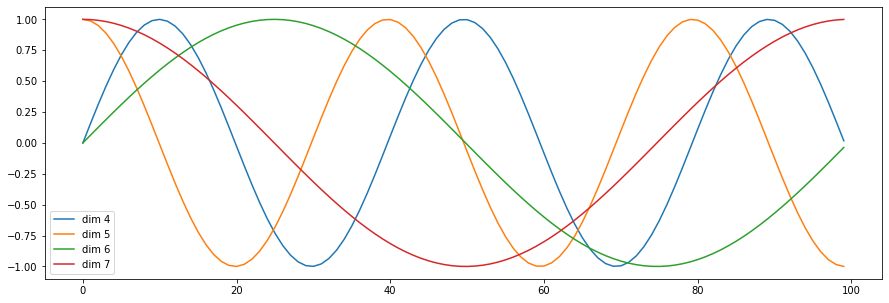

In [11]:
plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [12]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, # vocabulary 개수
                 hid_dim,   # token의 임베딩 차원
                 n_layers,  # self-attention + FCN 레이어를 몇 층 쌓을건지
                 n_heads,   # 몇 개의 multi-head self-attention
                 pf_dim,    # FCN의 dimension
                 dropout,  
                 device,
                 max_length = 100): 
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #     (src_len)              (1, src_len)  (batch_size, src_len)  
        
        
        #pos = [batch size, src len]
        src = self.tok_embedding(src)
        src = self.pos_embedding(src)

        for layer in self.layers:
            src = layer(src, src_mask)
            
        return src

##  pos 

In [13]:
pos = torch.arange(0, 10).unsqueeze(0).repeat(3, 1)
pos

tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [14]:
pos_embedding = nn.Embedding(10, 100)

In [15]:
pos_embedding(pos).shape

torch.Size([3, 10, 100])

In [16]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)

        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

In [17]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        # k.permute(0, 1, 3, 2) = [batch size, n heads, head dim, key len]
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        
        # n_heads * head_dim을 hid dim으로 합치는 부분
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

In [18]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

In [19]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = PositionalEncoding(hid_dim, dropout)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
        
        trg = self.tok_embedding(trg)
        trg = self.pos_embedding(trg)     
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [20]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

드디어 우리는 인코더와 디코더를 함께 넣는 부분과 mask를 만드는 부분까지 포함하는 `Seq2Seq` 차례입니다.

source mask는 source sequence가 `<pad>` 토큰과 같은지를 체크합니다. It is 1 where the token is not a `<pad>` token and 0 when it is. 그리고 나서 unsqueeze를 함으로서 shape이 **_[batch size, n heads, seq len, seq len]_**인 `energy` 함수에서 mask에 올바르게 broadcasting됩니다.

target mask는 살짝 더 복잡합니다. 우선, source mask를 만든 것 처럼 `pad` token을 위한 마스크를 만듭니다. 그리고 나서 `torch.tril`를 사용하여 `trg_sub_mask`인 "다음" mask를 만듭니다. 이것은 diagnoal 위는 0이고 아래는 input tensor로 설정되는 diagnoal matrix를 만들 것입니다. 이 경우에 input tensor는 1로 채워지게 됩니다. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

In [21]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [22]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [23]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

# `mask`에 대한 고찰

In [24]:
examples = ['i drink beer', 'i am drunk', 'i am good', 'you good? i am good'] 
preprocessed = [SRC.preprocess(example) for example in examples]
processed = SRC.process(preprocessed)
preprocessed, processed

([['i', 'drink', 'beer'],
  ['i', 'am', 'drunk'],
  ['i', 'am', 'good'],
  ['you', 'good', '?', 'i', 'am', 'good']],
 tensor([[   2, 5622,    0,    0,    3,    1,    1,    1],
         [   2, 5622,    0,    0,    3,    1,    1,    1],
         [   2, 5622,    0,    0,    3,    1,    1,    1],
         [   2,    0,    0, 2054, 5622,    0,    0,    3]]))

In [25]:
trg_examples = ['나 맥주 마신다', '나는 취했다', '나 괜찮다', '너 괜찮냐? 난 괜찮다'] 
trg_preprocessed = [TRG.preprocess(example) for example in trg_examples]
trg_processed = TRG.process(trg_preprocessed)
trg_preprocessed, trg_processed

([['나', '맥주', '마신다'],
  ['나는', '취했다'],
  ['나', '괜찮다'],
  ['너', '괜찮냐', '?', '난', '괜찮다']],
 tensor([[   2,    0,    0,    0,    3,    1,    1],
         [   2,    0,    0,    3,    1,    1,    1],
         [   2,    0,    0,    3,    1,    1,    1],
         [   2,    0,    0, 2417,    0,    0,    3]]))

In [26]:
self_attention = MultiHeadAttentionLayer(HID_DIM, ENC_HEADS, ENC_DROPOUT, device)
self_attention.to(device)

MultiHeadAttentionLayer(
  (fc_q): Linear(in_features=256, out_features=256, bias=True)
  (fc_k): Linear(in_features=256, out_features=256, bias=True)
  (fc_v): Linear(in_features=256, out_features=256, bias=True)
  (fc_o): Linear(in_features=256, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [27]:
src_mask = model.make_src_mask(processed)
src_mask

tensor([[[[ True,  True,  True,  True,  True, False, False, False]]],


        [[[ True,  True,  True,  True,  True, False, False, False]]],


        [[[ True,  True,  True,  True,  True, False, False, False]]],


        [[[ True,  True,  True,  True,  True,  True,  True,  True]]]])

In [28]:
embedding = nn.Embedding(5623, HID_DIM)

In [29]:
x, attention_score = self_attention(embedding(processed).to(device), embedding(processed).to(device), embedding(processed).to(device))

In [30]:
attention_score.shape # batch size, ENC_HEADS, seq_len, seq_len

torch.Size([4, 8, 8, 8])

In [31]:
src_mask.shape # batch size, 1, 1, seq_len

torch.Size([4, 1, 1, 8])

차원 차이가 나는데 어차피 head별로도 mask되야 되는 부분이 똑같고, 두번째 토큰에 대한 모든 토큰에 대한 mask되어야 하는 부분도 똑같아서
브로드캐스팅 처리가 됨

In [32]:
attention_score.masked_fill(src_mask.to(device) == False, 999).shape

torch.Size([4, 8, 8, 8])

https://github.com/GyuminJack/torchstudy/blob/main/04Apr/01_refcode/torch%20matmul.ipynb

energy = energy.masked_fill(mask == 0, -1e10)
- 레퍼런스 코드의 경우 1차원 어레이로 이루어져 있고, attention map 에서 패딩 컬럼만 제외시킴
- 패딩 로우는 로스에 합쳐지지 않기 때문에 2차원어레이로 마스크 맵을 구성하지 않은듯함.

In [33]:
mock_input = torch.Tensor([[1,2,3,4,5,1,0]])
seq_len = 7
attention_map = torch.rand(seq_len * seq_len).view(seq_len, seq_len)
src_mask = (mock_input != 0).unsqueeze(1)
src_mask

tensor([[[ True,  True,  True,  True,  True,  True, False]]])

In [34]:
attention_map.masked_fill(src_mask ==0, -0.1)

tensor([[[ 0.3799,  0.7548,  0.5510,  0.2733,  0.8119,  0.8075, -0.1000],
         [ 0.4464,  0.6879,  0.9362,  0.1866,  0.9944,  0.3711, -0.1000],
         [ 0.5311,  0.4884,  0.5394,  0.5663,  0.5395,  0.1924, -0.1000],
         [ 0.9803,  0.4411,  0.8113,  0.1611,  0.6006,  0.2010, -0.1000],
         [ 0.5212,  0.9141,  0.4030,  0.2852,  0.1432,  0.0438, -0.1000],
         [ 0.8859,  0.5689,  0.1641,  0.1774,  0.6898,  0.7209, -0.1000],
         [ 0.6918,  0.9106,  0.9929,  0.7770,  0.6841,  0.9489, -0.1000]]])

In [35]:
src_mask

tensor([[[ True,  True,  True,  True,  True,  True, False]]])

In [36]:
model.make_trg_mask(trg_processed.to(device))

tensor([[[[ True, False, False, False, False, False, False],
          [ True,  True, False, False, False, False, False],
          [ True,  True,  True, False, False, False, False],
          [ True,  True,  True,  True, False, False, False],
          [ True,  True,  True,  True,  True, False, False],
          [ True,  True,  True,  True,  True, False, False],
          [ True,  True,  True,  True,  True, False, False]]],


        [[[ True, False, False, False, False, False, False],
          [ True,  True, False, False, False, False, False],
          [ True,  True,  True, False, False, False, False],
          [ True,  True,  True,  True, False, False, False],
          [ True,  True,  True,  True, False, False, False],
          [ True,  True,  True,  True, False, False, False],
          [ True,  True,  True,  True, False, False, False]]],


        [[[ True, False, False, False, False, False, False],
          [ True,  True, False, False, False, False, False],
          [ True

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [37]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,632,837 trainable parameters


The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [38]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [39]:
model.apply(initialize_weights);

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

# Adam optimizer with learning rate warm-up and cool-down

In [40]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), 
                            betas=(0.9, 0.98),
                            eps = 1e-9,
                            lr = 1) # 초기 lr에 scheduler가 곱해주는 방식이므로, 이 경우에 1로 줘야함!! 

In [41]:
from torch.optim.lr_scheduler import LambdaLR

In [42]:
warmup_steps = 4000
scheduler = LambdaLR(optimizer, lambda step_num: HID_DIM ** (-0.5) * min((step_num + 1) ** (-0.5), 
                                                               (step_num + 1) * warmup_steps ** (-1.5)))

In [43]:
for _ in range(10):
    print(f'Epoch {_} learning rate : {scheduler.get_last_lr()[0]}')
    scheduler.step()

Epoch 0 learning rate : 2.4705294220065465e-07
Epoch 1 learning rate : 4.941058844013093e-07
Epoch 2 learning rate : 7.41158826601964e-07
Epoch 3 learning rate : 9.882117688026186e-07
Epoch 4 learning rate : 1.2352647110032732e-06
Epoch 5 learning rate : 1.482317653203928e-06
Epoch 6 learning rate : 1.7293705954045826e-06
Epoch 7 learning rate : 1.976423537605237e-06
Epoch 8 learning rate : 2.223476479805892e-06
Epoch 9 learning rate : 2.4705294220065464e-06


/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [44]:
warmup_steps = 4000
scheduler = LambdaLR(optimizer, lambda step_num: HID_DIM ** (-0.5) * min((step_num + 1) ** (-0.5), 
                                                               (step_num + 1) * warmup_steps ** (-1.5)))

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

# CrossEntropyLoss with label smoothing
https://github.com/pytorch/pytorch/issues/7455<br>
https://github.com/pytorch/pytorch/issues/11959<br>
그냥 trg만 바꿔주면 되겠지라고 생각했는데 CrossEntropyLoss가 trg이 long인 텐서만 받아서 생각보다 복잡한듯 하다<br>
또, ignore_index를 구현하려면 어떻게 해야하지?

In [45]:
import torch.nn.functional as F


def linear_combination(x, y, epsilon):
    return epsilon * x + (1 - epsilon) * y


def reduce_loss(loss, reduction='mean'):
    return loss.mean() if reduction == 'mean' else loss.sum() if reduction == 'sum' else loss


class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, epsilon: float = 0.1, reduction='mean', ignore_index=-100):
        super().__init__()
        self.epsilon = epsilon
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, pred, target):
        n = pred.size()[-1]
        log_pred = F.log_softmax(pred, dim=-1)
        loss = reduce_loss(-log_pred.sum(dim=-1), self.reduction)
        nll = F.nll_loss(log_pred, target, reduction=self.reduction, ignore_index=self.ignore_index)
        return linear_combination(loss / n, nll, self.epsilon)

In [46]:
# class LabelSmoothingLoss(nn.Module):
#     def __init__(self, classes, smoothing=0.0, dim=-1, ignore_index = -999):
#         super(LabelSmoothingLoss, self).__init__()
#         self.confidence = 1.0 - smoothing
#         self.smoothing = smoothing
#         self.cls = classes
#         self.dim = dim

#     def forward(self, pred, target):
#         pred = pred.log_softmax(dim=self.dim)
#         with torch.no_grad():
#             # true_dist = pred.data.clone()
#             true_dist = torch.zeros_like(pred)
#             true_dist.fill_(self.smoothing / (self.cls - 1))
#             true_dist.scatter_(2, target.data.unsqueeze(2), self.confidence)
#         return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [47]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_VOCAB_LEN = len(TRG.vocab)

In [48]:
output, _ = model(processed.to(device), trg_processed[:, :-1].to(device))

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [49]:
output.shape, trg_processed[:, 1:].shape

(torch.Size([4, 6, 5893]), torch.Size([4, 6]))

In [50]:
output = output.contiguous().view(-1, TRG_VOCAB_LEN)
trg_processed = trg_processed[:,1:].contiguous().view(-1)

## 톺아보기 

In [51]:
output = output.log_softmax(-1)

In [52]:
device = 'cpu'

In [53]:
is_target = trg_processed == 1

In [54]:
is_target, is_target.shape

(tensor([False, False, False, False,  True,  True, False, False, False,  True,
          True,  True, False, False, False,  True,  True,  True, False, False,
         False, False, False, False]),
 torch.Size([24]))

In [55]:
trg_processed.masked_fill(is_target, 0.)

tensor([   0,    0,    0,    3,    0,    0,    0,    0,    3,    0,    0,    0,
           0,    0,    3,    0,    0,    0,    0,    0, 2417,    0,    0,    3])

In [56]:
true_dist = torch.zeros_like(output)
true_dist = true_dist.fill_(0.01 / (TRG_VOCAB_LEN - 1)).to(device)

In [57]:
true_dist.shape, is_target.shape

(torch.Size([24, 5893]), torch.Size([24]))

In [58]:
true_dist = true_dist.masked_fill(is_target.unsqueeze(1), 0)

In [59]:
torch.Tensor([[1, 2], [3, 4]]) 

tensor([[1., 2.],
        [3., 4.]])

In [60]:
output.shape, trg_processed.shape

(torch.Size([24, 5893]), torch.Size([24]))

## scatter라는 난해한 모듈
https://github.com/long8v/torch_study/blob/master/torch_toy.ipynb

In [61]:
true_dist.shape

torch.Size([24, 5893])

In [62]:
trg_processed

tensor([   0,    0,    0,    3,    1,    1,    0,    0,    3,    1,    1,    1,
           0,    0,    3,    1,    1,    1,    0,    0, 2417,    0,    0,    3])

In [63]:
true_dist.shape

torch.Size([24, 5893])

In [64]:
true_dist.shape, trg_processed.shape

(torch.Size([24, 5893]), torch.Size([24]))

In [65]:
true_dist.scatter_(1, trg_processed.unsqueeze(1), 1.0 - 0.01)

tensor([[9.9000e-01, 1.6972e-06, 1.6972e-06,  ..., 1.6972e-06, 1.6972e-06,
         1.6972e-06],
        [9.9000e-01, 1.6972e-06, 1.6972e-06,  ..., 1.6972e-06, 1.6972e-06,
         1.6972e-06],
        [9.9000e-01, 1.6972e-06, 1.6972e-06,  ..., 1.6972e-06, 1.6972e-06,
         1.6972e-06],
        ...,
        [9.9000e-01, 1.6972e-06, 1.6972e-06,  ..., 1.6972e-06, 1.6972e-06,
         1.6972e-06],
        [9.9000e-01, 1.6972e-06, 1.6972e-06,  ..., 1.6972e-06, 1.6972e-06,
         1.6972e-06],
        [1.6972e-06, 1.6972e-06, 1.6972e-06,  ..., 1.6972e-06, 1.6972e-06,
         1.6972e-06]])

In [66]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.0, dim=-1, 
                 unk_index = -999, pad_index = -999):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.dim = dim
        self.unk_index = unk_index
        self.pad_index = pad_index
    def forward(self, pred, target):
        pred = pred.log_softmax(dim=self.dim)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.cls - 1 - 1 - 1)) # pad, unk token
#             print(f'target shape {target.shape} pred shape {pred.shape}')
            is_pad = target == self.unk_index
            is_unk = target == self.pad_index 
            is_target = torch.logical_or(is_pad, is_unk)
#             print('is_target shape ', is_target.shape)
#             is_target = is_target.unsqueeze(1)
            true_dist = true_dist.masked_fill(is_target.unsqueeze(1), 1e-10)
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))

In [67]:
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_UNK_IDX = TRG.vocab.stoi[TRG.unk_token]
TRG_VOCAB_LEN = len(TRG.vocab)

criterion = LabelSmoothingCrossEntropy()

# 의아한 점 : batch로 묶어서 eos위치가 다 다를텐데 [:, :-1] 한다고 eos가 안들어가나?

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

`<eos>` 토큰을 예측하기를 바라나, input으로 넣어주길 원하지 않으므로 시퀀스 끝 부분을 slice해줍시다.
그러므로, 

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. loss 를 계산할 때, 앞의 `<sos>` 토큰을 slice 해버리고 `<eos>`토큰은 남기고 loss 를 구합시다.

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

# 새로 알게 된 것 
`scheduler.step()`이 `optimizer.step()`뒤로 와야 함<br>
https://stackoverflow.com/questions/59017023/pytorch-learning-rate-scheduler<br>
Prior to PyTorch 1.1.0, the learning rate scheduler was expected to be called before the optimizer’s update; 1.1.0 changed this behavior in a BC-breaking way. If you use the learning rate scheduler (calling scheduler.step()) before the optimizer’s update (calling optimizer.step()), this will skip the first value of the learning rate schedule. If you are unable to reproduce results after upgrading to PyTorch 1.1.0, please check if you are calling scheduler.step() at the wrong time.

# 궁금증 2 :아니 VIEW 왜 했었던 거지??

In [68]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg
        

        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [69]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

We then define a small function that we can use to tell us how long an epoch takes.

In [70]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [71]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 01 | Time: 0m 16s
	Train Loss: 8.553 | Train PPL: 5182.286
	 Val. Loss: 8.581 |  Val. PPL: 5330.627
Epoch: 02 | Time: 0m 17s
	Train Loss: 8.265 | Train PPL: 3885.096
	 Val. Loss: 8.427 |  Val. PPL: 4567.182
Epoch: 03 | Time: 0m 17s
	Train Loss: 8.002 | Train PPL: 2987.427
	 Val. Loss: 8.284 |  Val. PPL: 3958.760
Epoch: 04 | Time: 0m 17s
	Train Loss: 7.761 | Train PPL: 2346.984
	 Val. Loss: 8.155 |  Val. PPL: 3479.215
Epoch: 05 | Time: 0m 17s
	Train Loss: 7.562 | Train PPL: 1924.280
	 Val. Loss: 8.048 |  Val. PPL: 3126.848
Epoch: 06 | Time: 0m 18s
	Train Loss: 7.380 | Train PPL: 1603.555
	 Val. Loss: 7.963 |  Val. PPL: 2872.955
Epoch: 07 | Time: 0m 18s
	Train Loss: 7.248 | Train PPL: 1405.574
	 Val. Loss: 7.896 |  Val. PPL: 2686.521
Epoch: 08 | Time: 0m 17s
	Train Loss: 7.131 | Train PPL: 1250.102
	 Val. Loss: 7.841 |  Val. PPL: 2543.464
Epoch: 09 | Time: 0m 17s
	Train Loss: 7.020 | Train PPL: 1118.644
	 Val. Loss: 7.794 |  Val. PPL: 2424.987
Epoch: 10 | Time: 0m 16s
	Train Loss:

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [72]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 7.806 | Test PPL: 2455.833 |


/home/long8v/anaconda3/envs/long36v/lib/python3.6/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()

    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask.to(device))

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        
        trg_tensor = trg_tensor.to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

First, we'll get an example from the training set.

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [ ]:
model.device

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

In [ ]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

In [ ]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

A perfect translation!

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

In [ ]:
display_attention(src, translation, attention)

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)